In [1]:

from fastai.torch_basics import *
from fastai.data.all import *
from fastai.tabular.data import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.basics import *
from fastrenewables.tabular.core import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.model import *
from fastrenewables.utils import *
from fastrenewables.gan.learner import *

from fastrenewables.timeseries.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_dls(cat_names, cont_names):
    pd.options.mode.chained_assignment=None
    
    dls = RenewableDataLoaders.from_files(glob.glob("../data/*.h5"), 
                                          pre_procs=[FilterYear(year=2020)],
                                          procs = [NormalizePerTask(norm_type="minmaxnorm")],
                                          cat_names=cat_names, cont_names=cont_names, y_names=cont_names)
    return dls



In [3]:
cont_names = ['WindSpeed58m', 'PS_SFC_0_M',  "PowerGeneration"]
cat_names = ['TaskID']

In [4]:
dls = get_dls(cat_names, cont_names)

In [5]:
n_cats = len(dls.train_ds.cats.TaskID.unique()) #len(cat_names)
n_conts =  len(cont_names)

In [6]:
emb_module = EmbeddingModule(categorical_dimensions=[n_cats+1])
# emb_module = None
emb_module

EmbeddingModule(
  (embeddings): ModuleList(
    (0): Embedding(4, 3)
  )
)

In [7]:
n_samples = 1024
n_classes = 2 # TODO is this n_cats for auxilary?
n_features = n_conts
# batch_size = 512
n_z = 10
n_in = n_features
n_hidden = 256
epochs = 10
n_gen = 1
n_dis = 1
batch_norm = True

In [8]:
structure = [n_z, n_hidden, n_hidden, n_hidden, n_in]

In [9]:
model = get_gan_model(structure=structure, 
                      n_classes=n_classes, 
                      emb_module=emb_module, 
                      bn=batch_norm, 
                      gan_type='bce')

In [10]:
lr = 1e-4
learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
learner.fit(dls.train, epochs=epochs, lr=lr, plot_epochs=epochs, save_model=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.13s/it]


In [11]:
all_fakes_conts, all_cats = [], []

In [12]:
for x_cat, x_cont, y in dls.valid:
    x_fake = learner.generate_samples(x_cat, x_cont)
    all_fakes_conts.append(x_fake)
    all_cats.append(x_cat)

In [13]:
all_fakes_conts = torch.cat(all_fakes_conts)
all_cats = torch.cat(all_cats)

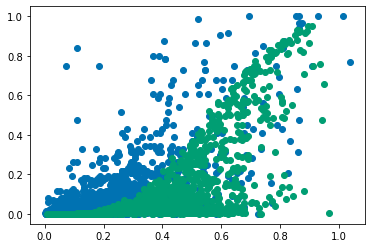

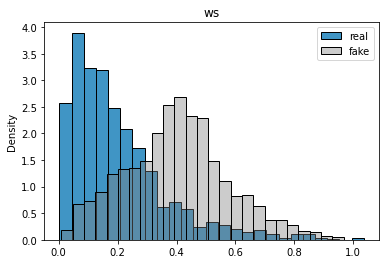

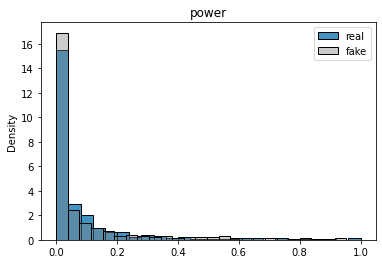

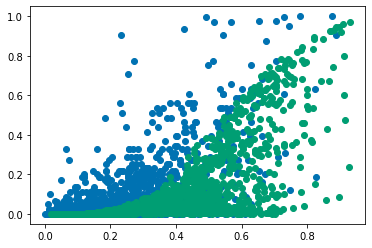

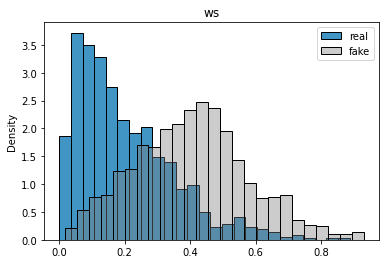

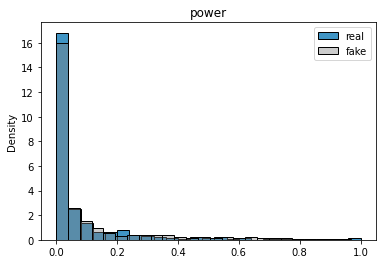

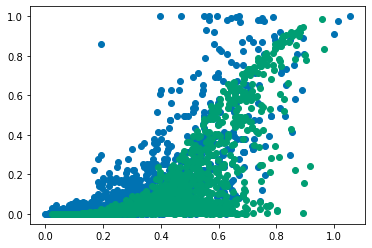

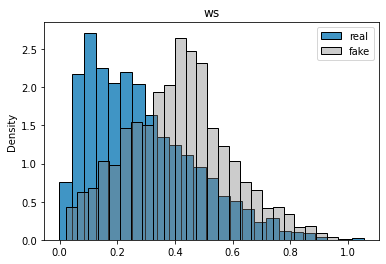

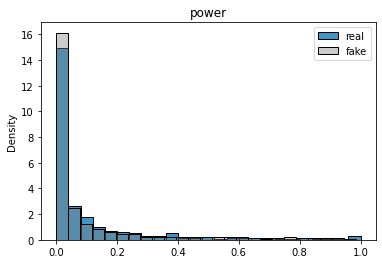

In [14]:
for tid in all_cats.unique():
    mask = (dls.valid_ds.cats == float(tid)).values
    ws = dls.valid_ds.conts.WindSpeed58m.values[mask.reshape(-1)]
    power = dls.valid_ds.conts.PowerGeneration.values[mask.reshape(-1)]
    plt.scatter(ws, power)
    mask = all_cats == float(tid)
    
    ws_fake = all_fakes_conts[mask.reshape(-1),0]
    power_fake = all_fakes_conts[mask.reshape(-1),-1]
    plt.scatter(ws_fake,power_fake)
    plt.show()
    
    n_bins = 25
    stat_type = "probability"
    stat_type = "density"
    sns.histplot(ws, label="real", stat=stat_type, bins=n_bins)
    sns.histplot(ws_fake, label="fake", alpha=0.4, color="grey", stat=stat_type, bins=n_bins)
    plt.title("ws")
    plt.legend()
    plt.show()
    
    sns.histplot(power, label="real", stat=stat_type, bins=n_bins)
    sns.histplot(power_fake, label="fake", alpha=0.4, color="grey", stat=stat_type, bins=n_bins)
    plt.title("power")
    plt.legend()
    plt.show()

In [15]:
def get_dls_ts(cat_names, cont_names):
    pd.options.mode.chained_assignment=None
    
    dls = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5"), 
                                          pre_procs=[FilterYear(year=2020), FilterInconsistentSamplesPerDay],
                                          procs = [NormalizePerTask(norm_type="minmaxnorm")],
                                          cat_names=cat_names, cont_names=cont_names, y_names=cont_names)
    return dls



In [16]:
dls_ts = get_dls_ts(cat_names, cont_names)

In [17]:
emb_module = EmbeddingModule(categorical_dimensions=[n_cats+1])
emb_module

EmbeddingModule(
  (embeddings): ModuleList(
    (0): Embedding(4, 3)
  )
)

In [95]:
div_factor = 16
structure = [n_z, n_hidden//div_factor, n_hidden//div_factor, n_hidden//div_factor, n_in]
model = get_gan_model(structure=structure, 
                      n_classes=n_classes, 
                      emb_module=emb_module, 
                      bn=batch_norm, 
                      gan_type='bce',
                      model_type="tcn")

In [105]:
lr = 1e-4
epochs = 20
learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
learner.fit(dls_ts.train, epochs=epochs, lr=lr, plot_epochs=epochs, save_model=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.64it/s]


In [106]:
all_fakes_conts, all_cats = [], []
for x_cat, x_cont, y in dls_ts.valid:
    x_fake = learner.generate_samples(x_cat, x_cont)
    all_fakes_conts.append(x_fake)
    all_cats.append(x_cat)
    
all_fakes_conts = torch.cat(all_fakes_conts)
all_cats = torch.cat(all_cats)

In [107]:
all_fakes_conts.shape, all_cats.shape

(torch.Size([192, 3, 24]), torch.Size([192, 1, 24]))

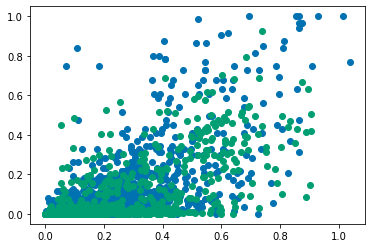

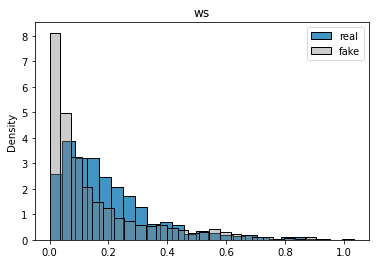

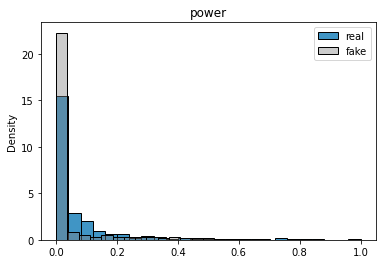

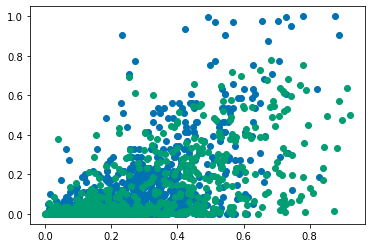

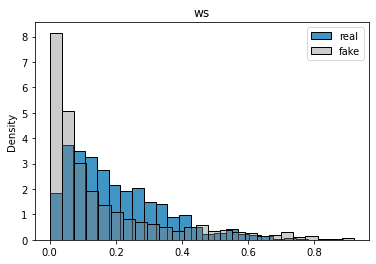

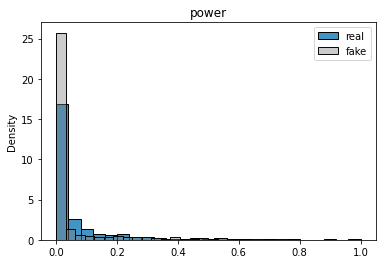

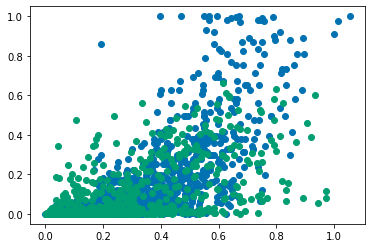

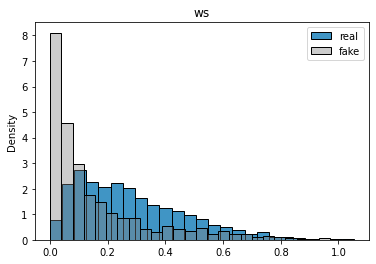

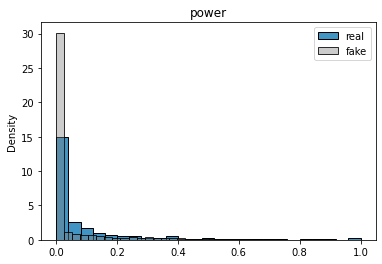

In [108]:
for tid in all_cats.unique():
    mask = (dls.valid_ds.cats == float(tid)).values
    ws = dls.valid_ds.conts.WindSpeed58m.values[mask.reshape(-1)]
    power = dls.valid_ds.conts.PowerGeneration.values[mask.reshape(-1)]
    plt.scatter(ws, power)
    
    
    mask = flatten_ts(all_cats) == float(tid)
    ws_fake = flatten_ts(all_fakes_conts)[mask.reshape(-1),0]
    power_fake = flatten_ts(all_fakes_conts)[mask.reshape(-1),-1]
    plt.scatter(ws_fake,power_fake)
    plt.show()
    
    n_bins = 25
    stat_type = "probability"
    stat_type = "density"
    sns.histplot(ws, label="real", stat=stat_type, bins=n_bins)
    sns.histplot(ws_fake, label="fake", alpha=0.4, color="grey", stat=stat_type, bins=n_bins)
    plt.title("ws")
    plt.legend()
    plt.show()
    
    sns.histplot(power, label="real", stat=stat_type, bins=n_bins)
    sns.histplot(power_fake, label="fake", alpha=0.4, color="grey", stat=stat_type, bins=n_bins)
    plt.title("power")
    plt.legend()
    plt.show()

In [109]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

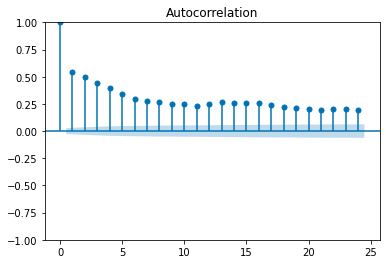

In [110]:
plot_acf(dls.valid_ds.conts.sort_index().PowerGeneration, lags=24)
plt.show()

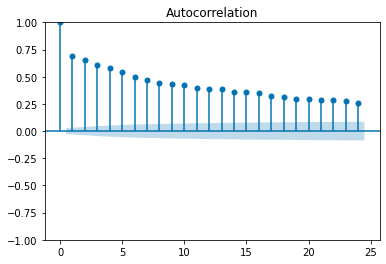

In [111]:
plot_acf(dls.valid_ds.conts.sort_index().WindSpeed58m, lags=24)
plt.show()

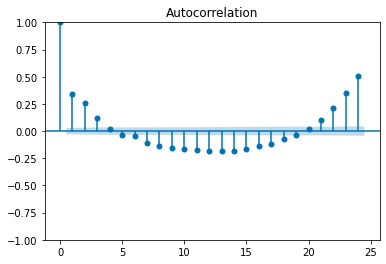

In [112]:
plot_acf(all_fakes_conts[:,0,:].reshape(-1), lags=24)
plt.show()

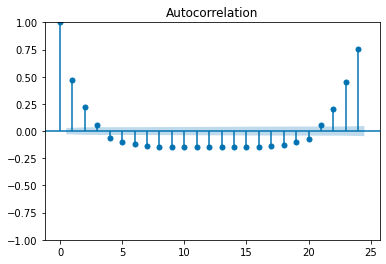

In [113]:
plot_acf(all_fakes_conts[:,2,:].reshape(-1), lags=24)
plt.show()